In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn import linear_model, metrics, feature_selection


plt.rcParams['figure.figsize']=10,5

#### Introduction
Stuff boost is a game mechanic in Out of the Park Baseball where a pitcher that is listed as a starter in the game will have a certain Stuff rating, but when they are switched to a reliever by changing their listed position, their stuff rating is improved depending on various factors. Generally pitchers with two really good pitches, and average to poor supporting pitches will receive the highest boost when shifted to the bullpen, whereas pitchers with five or six pitches with similar ratings will receive little to no boost. There are other factors that play into it, but that's the gist of it.

This game mechanic is present currently in the base game for OOTP 22, and has been present in Perfect Team in previous iterations. During the introductory stream for Perfect Team 22, it was announced that stuff boost was removed from this year's iteration of Perfect Team.

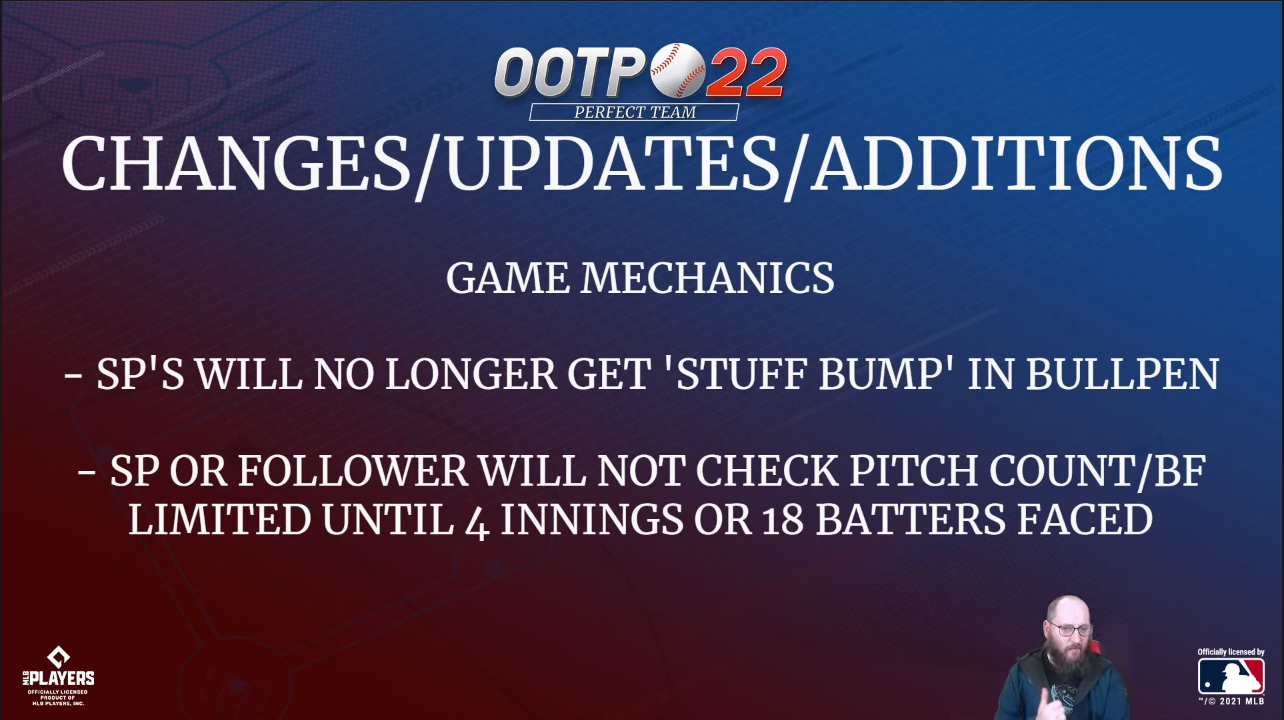

As Kris said during the announcement stream, "Starting pitcher stuff in the bullpen has been eliminated. If you put a starting pitcher in the bullpen they will no longer get an increase to stuff."

Despite this announcement, it's my belief this game mechanic is still present within PT22, albeit less severe than previously observed. The change in a pitcher's stuff may not be shown to users when they switch a pitcher's role from starter to reliever, or vice versa, but the same affect of stuff boost has in the engine is still present.

**TLDR:**
* Stuff boost is likely still modeled in the game despite announcments indicating it was removed from the game.
* Ratings for certain relievers (mostly Live cards) are likely wrong as shown in-game.

#### Bronze Quick Tournaments
The following data comes from Bronze Quick Best of Seven Tournmanets since the latest live card update that occured on June 28th, 2021. At the time I put this analysis together, I had pulled 814 tournaments worth of data, with 146,000 games worth approximately 11.2  million plate appearances. 

Pitchers who appeared as both a reliever and a starter for a team in the tournament were removed from this data, leaving only pitchers who appeared in relief in the following section. Further, only those pitchers who faced more than 2,000 batters as a reliever were included as a way to tamp down on the inherent noise that occurs when sample sizes are smaller than that. For this notebook, strikeout rate is defined as the number of batters struck out divided by the total number of batters faced.

<AxesSubplot:xlabel='pitching_ratings_vsr_stuff', ylabel='k_rate'>

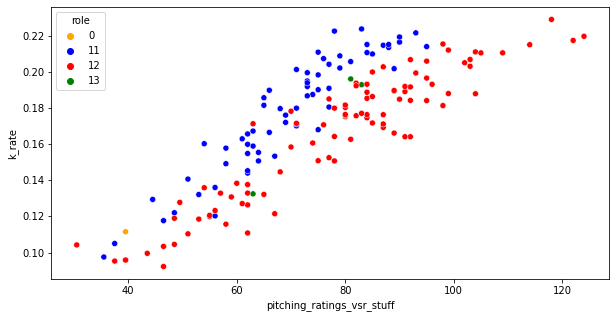

In [2]:
bz_relief = pd.read_csv('bronze_relief.csv')
#When I load the data from the card db, I convert ratings to 1-200 scale. This is just reversing that conversion
bz_relief['pitching_ratings_vsr_stuff'] = bz_relief['pitching_ratings_vsr_stuff'] / 2
bz_relief['pitching_ratings_vsl_stuff'] = bz_relief['pitching_ratings_vsl_stuff'] / 2

#Again, k_rate is number of strikouts per batters faced
bz_relief['k_rate'] = bz_relief['k'] / bz_relief['bf']
sns.scatterplot(data=bz_relief, x='pitching_ratings_vsr_stuff',
                y='k_rate',
                hue='role',
                palette=['orange','blue','red','green'])


In the above plot, a pitcher's dot is colored based on their role as defined in the Perfect Team 22 card database that was updated on July 5th, 2021. I am using the same mapping from the base game SQL dump, where 11 = Starter, 12 = Reliever, and 13 = Closer. A player with a role of 0 is someone listed as a hitter in the card database.

It's clear that pitchers with role of "starter" have a different strikeout rate relative to their stuff rating (in this case versus right_handed batters) relative to relief pitchers. A starter with a strikeout rate of about .16 percent has a stuff rating of about 60-62. A relief pitcher with the same striekout rate has a stuff rating of about 77-80, based on this plot.

The plot below is showing the same data, but with regression lines based on the pitcher's role (closers were removed for clarity). This helps show that as a pitcher's strikeout rate increases, the stuff rating begins to diverge at an increasing rate relative to the pitcher's listed role. This would be expected if stuff boost was still in the game for starters, as generally pitchers with higher stuff as starters would get a higher boost when switched to a relief role (not across the board as there's a ton of factors that go into stuff boost, but generally it's easier for a 65 stuff SP to a 75 stuff RP compared to a 40 stuff SP to a 60 stuff RP).

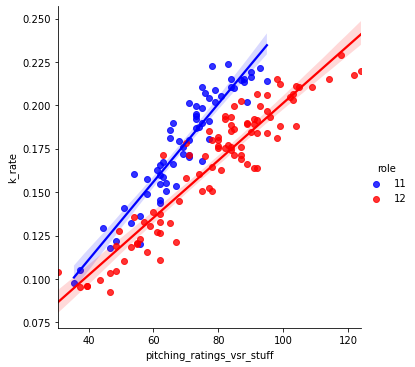

In [3]:
sns.lmplot(data=bz_relief.loc[bz_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsr_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

This divergence based on role is also present when looking at the pitcher's stuff rating versus LHB, so we can largely rule out any affects that the bronze meta has in terms of batter handedness playing a major impact, though how stuff plays up against RHB compared to LHB could still be different from each other.

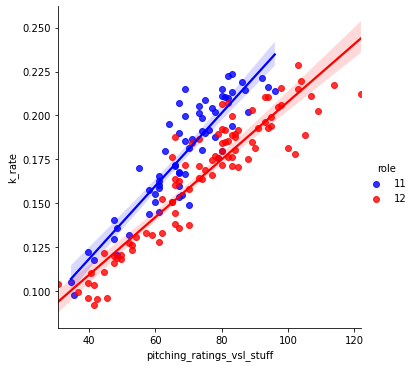

In [4]:
sns.lmplot(data=bz_relief.loc[bz_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsl_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

A quick detour to discuss the use of followers that could impact this analysis. I haven't looked explicitly at followers and how they perform compared to when they are just used as starters, but it would be my assumption the engine treats them as starters in terms of performance, which would lead to lower overall strikeout rates for followers than pure relivers. That would lead to the opposite results from what's being seen in the game engine, but let's remove any pitcher who was likely used as a follower anyway. 

This next data set removes any pitcher who threw more than 30 pitches per game as a pure reliever for a team during a tournament. These pitchers never started a game, the same as the data we've been looking at. What's observed is close to what we've already been seeing.

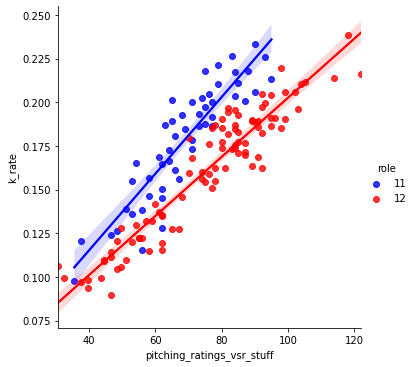

In [5]:
bz_relief_sub30 = pd.read_csv('bronze_relief_sub30.csv')
#When I load the data from the card db, I convert ratings to 1-200 scale. This is just reversing that conversion
bz_relief_sub30['pitching_ratings_vsr_stuff'] = bz_relief_sub30['pitching_ratings_vsr_stuff'] / 2
bz_relief_sub30['pitching_ratings_vsl_stuff'] = bz_relief_sub30['pitching_ratings_vsl_stuff'] / 2

#Again, k_rate is number of strikouts per batters faced
bz_relief_sub30['k_rate'] = bz_relief_sub30['k'] / bz_relief_sub30['bf']

sns.lmplot(data=bz_relief_sub30.loc[bz_relief_sub30['role'].isin([11,12]), :],
           x='pitching_ratings_vsr_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])


Moving back to the original data set. When comparing strikeout rates for starters and relievers, pitchers that are listed as starters (role_11 = 1 in the plot below) in the card database have higher strikeout percentages in relief than those pitchers who are listed as relievers or closers.

<AxesSubplot:xlabel='role_11', ylabel='k_rate'>

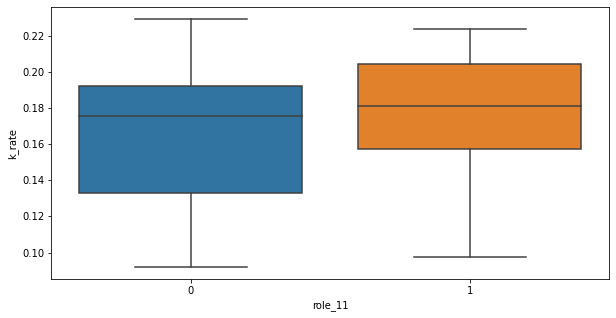

In [6]:
bz_relief['throws'] = bz_relief['throws'].astype('object')
bz_relief['role'] = bz_relief['role'].astype('object')
df = bz_relief[['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'pitching_ratings_vsl_stuff',
       'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control','throws','role','k_rate']]

df = pd.get_dummies(df)

sns.boxplot(x="role_11", y="k_rate", data=df)

At this point we know that starting pitchers have higher strikeout rates than relievers while in the bullpen, while having lower stuff ratings than their relief counterparts.

We can approximate how much having an SP in the bullpen is worth in terms of stuff through linear regression. First I'll fit a model without a player's "role" being considered to see how it performs. This will be the "base" model for future comparisions, where I'll be tracking the mean squared error (MSE) and r2 score when the model is fitted on the whole dataset, as well as the best MSE when performing 10-fold cross validation. These three scores will form the basis for comparing various models against each other.

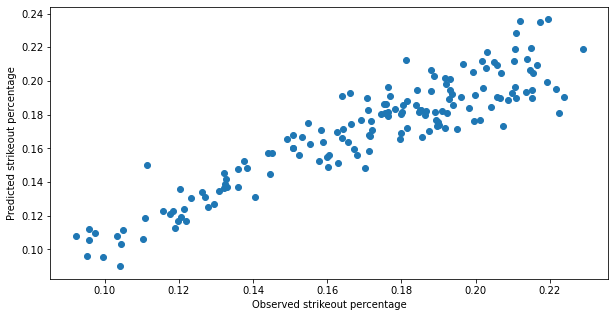

In [7]:
x = ['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'pitching_ratings_vsl_stuff',
       'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control',
       'throws_1']

y = 'k_rate'

lr = linear_model.RidgeCV(cv=10, scoring='neg_mean_squared_error')

lr.fit(df[x], df[y])

plt.scatter(df[y], lr.predict(df[x]))
plt.xlabel('Observed strikeout percentage')
plt.ylabel('Predicted strikeout percentage')
plt.show()

In [8]:
print(lr.best_score_)

scores = [{
    'model':'base',
    'best_cv_score': lr.best_score_,
    'full_mse': metrics.mean_squared_error(df[y], lr.predict(df[x])),
    'full_r2': metrics.r2_score(df[y], lr.predict(df[x]))
}]

scores

-0.0001894679210905506


[{'model': 'base',
  'best_cv_score': -0.0001894679210905506,
  'full_mse': 0.00017580856952586566,
  'full_r2': 0.8523005339769121}]

It's not the tightest fitting model I've ever produced in OOTP, but it's "generally" there. This has an r2 score of .85, and a mean squared error (MSE) of .00018. I'll be keeping track of how various models perform 

How does a model with role added perform when predicting strikeout percentage?

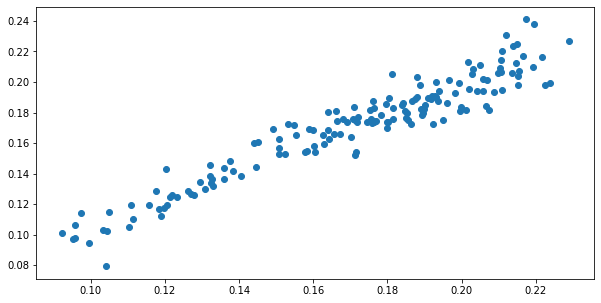

In [9]:
x = ['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'pitching_ratings_vsl_stuff',
       'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control', 'throws_1',
       'role_11']

lr.fit(df[x], df[y])

plt.scatter(df[y], lr.predict(df[x]))
plt.show()

In [10]:
print(lr.best_score_)

scores.append({
    'model':'base_with_roll',
    'best_cv_score': lr.best_score_,
    'full_mse': metrics.mean_squared_error(df[y], lr.predict(df[x])),
    'full_r2': metrics.r2_score(df[y], lr.predict(df[x]))
})

scores[1]

-0.00011199868550832763


{'model': 'base_with_roll',
 'best_cv_score': -0.00011199868550832763,
 'full_mse': 0.00010014296961488085,
 'full_r2': 0.9158683608087256}

It's a much tighter fit compared to the first model, has a higher r2 score, and a lower MSE, which supports the theory that stuff boost is still a game mechanic within OOTP Perfect Team. As a quick aside, it's interesting that there appears to be a linear break around 16 percent in both models, which sits roughly halfway between the observed and predicted strikeout rates. This phenomena is readily apparent in a lot of batting ratings, where players with ratings less than average follow one formula, and players above average have a separate formula.

Can a better prediction model be built based on the underlying factors that determine stuff boost in the base game? This next takes the top two rated pitches for a pitcher, along with their velocity, and ignores the stuff rating completely. Movement and control ratings are left in the model.

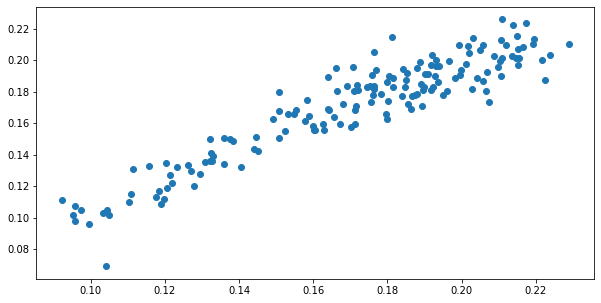

In [11]:
pitches = pd.DataFrame(np.sort(bz_relief[['pitching_ratings_pitches_fastball', 'pitching_ratings_pitches_slider',
       'pitching_ratings_pitches_curveball',
       'pitching_ratings_pitches_screwball',
       'pitching_ratings_pitches_forkball',
       'pitching_ratings_pitches_changeup', 'pitching_ratings_pitches_sinker',
       'pitching_ratings_pitches_splitter',
       'pitching_ratings_pitches_knuckleball',
       'pitching_ratings_pitches_cutter',
       'pitching_ratings_pitches_circlechange',
       'pitching_ratings_pitches_knucklecurve']].values), index=bz_relief.index)

df['top2'] = pitches[10] + pitches[11]
df['diff3'] = pitches[10] - pitches[9]
df['velo'] = bz_relief['pitching_ratings_misc_velocity']

x = ['pitching_ratings_vsr_movement', 'pitching_ratings_vsr_control', 
     'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control', 
     'top2', 'diff3', 'velo']

lr.fit(df[x], bz_relief[y])

plt.scatter(bz_relief[y], lr.predict(df[x]))
plt.show()

In [12]:
print(lr.best_score_)

scores.append({
    'model':'boost_wo_stuff',
    'best_cv_score': lr.best_score_,
    'full_mse': metrics.mean_squared_error(df[y], lr.predict(df[x])),
    'full_r2': metrics.r2_score(df[y], lr.predict(df[x]))
})

scores[2]

-0.0001639952961020583


{'model': 'boost_wo_stuff',
 'best_cv_score': -0.0001639952961020583,
 'full_mse': 0.0001498694189961486,
 'full_r2': 0.8740924107475609}

The model still performs worse than one where a pitcher's role in the database is included with a .87 r2-score and an MSE of .00015. If the card's stuff ratings were included, as well as the top two pitches and velocity (going to run into colinearity issues here but let's do it anyway), how does it perform?

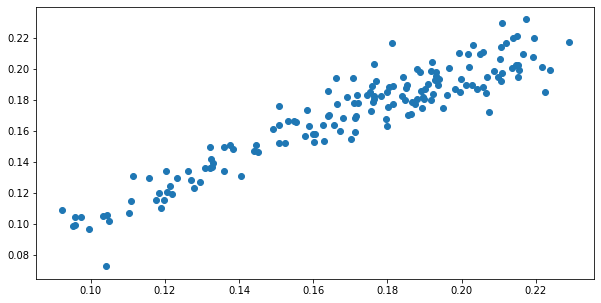

In [13]:
x = ['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'pitching_ratings_vsl_stuff',
       'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control',
      'top2', 'diff3', 'velo']

lr.fit(df[x], bz_relief[y])

plt.scatter(bz_relief[y], lr.predict(df[x]))
plt.show()

In [14]:
print(lr.best_score_)

scores.append({
    'model':'boost_w_stuff',
    'best_cv_score': lr.best_score_,
    'full_mse': metrics.mean_squared_error(df[y], lr.predict(df[x])),
    'full_r2': metrics.r2_score(df[y], lr.predict(df[x]))
})

scores[3]

-0.0001592122702947732


{'model': 'boost_w_stuff',
 'best_cv_score': -0.0001592122702947732,
 'full_mse': 0.00014231914151588637,
 'full_r2': 0.880435514244554}

While it performs better than the model that doesn't incorporate stuff, it still doesn't perform as well as the one that includes the pitcher's role from the card database in the model. How does a model that includes everything discussed so far perform (stuff, movement, contorl, role, handedness, top two pitches, difference to third pitch, and velocity)?

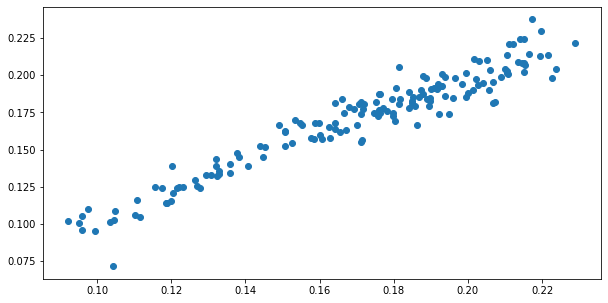

In [15]:
x = ['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'pitching_ratings_vsl_stuff',
       'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control',
     'throws_1','role_11', 'top2', 'diff3', 'velo'
    ]

lr.fit(df[x], bz_relief[y])

plt.scatter(bz_relief[y], lr.predict(df[x]))
plt.show()

In [16]:
print(lr.best_score_)

scores.append({
    'model':'full',
    'best_cv_score': lr.best_score_,
    'full_mse': metrics.mean_squared_error(df[y], lr.predict(df[x])),
    'full_r2': metrics.r2_score(df[y], lr.predict(df[x]))
})

scores[4]

-0.00010551055016536986


{'model': 'full',
 'best_cv_score': -0.00010551055016536986,
 'full_mse': 8.87492486992137e-05,
 'full_r2': 0.9254403998725695}

What we see is the best fitting model so far, even better than the base model with roll included. Below is how all five models stack up against each other. best_cv and full_mse scores the closer to 0 the value is the better the performance, whereas the close to 1 the r2 is, the better the peformance.

Both models that include the pitcher's role from the database perform the best, whereas the two models that try to incorporate a predictive versions of stuff boost from the base game and previous version perform better than just the base model that only use the stuff/movement/control ratings for the pitcher.

In [17]:
scoring = pd.DataFrame(scores)
scoring

,model,best_cv_score,full_mse,full_r2
0,base,-0.000189,0.000176,0.852301
1,base_with_roll,-0.000112,0.000100,0.915868
2,boost_wo_stuff,-0.000164,0.000150,0.874092
3,boost_w_stuff,-0.000159,0.000142,0.880436
4,full,-0.000106,0.000089,0.925440


So far I've been choosing features and just plugging them into models and seeing how they form. We can use a process called recursive feature elemination to go through all the combination of variables and remove them one at a time to see what combination of variables produces the best model. This next block does that. What's printed out afterwards are the all variables, along with whether they were chosen in the best model or not.

In [18]:
rfecv = feature_selection.RFECV(linear_model.Ridge(), cv=10, scoring='neg_mean_squared_error')
x = ['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'pitching_ratings_vsl_stuff',
       'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control',
     'throws_1','role_11', 'top2', 'diff3', 'velo'
    ]

rfecv.fit(df[x], bz_relief[y])

dict(zip(x, rfecv.support_))

{'pitching_ratings_vsr_stuff': True,
 'pitching_ratings_vsr_movement': True,
 'pitching_ratings_vsr_control': True,
 'pitching_ratings_vsl_stuff': True,
 'pitching_ratings_vsl_movement': True,
 'pitching_ratings_vsl_control': True,
 'throws_1': True,
 'role_11': True,
 'top2': True,
 'diff3': True,
 'velo': True}

All ten variables were selected after performing RFECV. We can inspect how the model improved at various levels of variables to see if there was steady improvement over the 10, or if there was a leveling off.

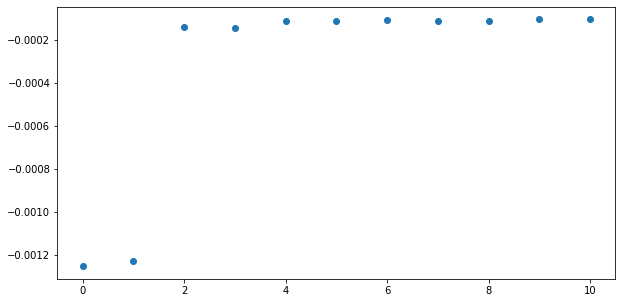

In [19]:
plt.scatter([i for i in range(len(rfecv.grid_scores_))], rfecv.grid_scores_)
plt.show()

After the third variable is added to the model, we see that leveling where additional variables don't add as much value to the overall performance. So what combination of three variables gets us to that big jump in performance?

In [20]:
combos = combinations(x, 3)

combo_scores = []
for combo in combos:
    lr.fit(df[list(combo)], bz_relief[y])
    if lr.best_score_ > -0.00015:
        print(combo)
        print(lr.best_score_)

('pitching_ratings_vsr_stuff', 'pitching_ratings_vsl_stuff', 'role_11')
-0.00011514628278193499
('pitching_ratings_vsr_stuff', 'throws_1', 'role_11')
-0.00013943903631623652
('pitching_ratings_vsr_stuff', 'role_11', 'top2')
-0.00014045370180350807
('pitching_ratings_vsl_stuff', 'role_11', 'top2')
-0.00013581690673103566


Every combination of three variables that gets to an MSE of less than 0.00015 includes the pitcher's role in the database, as well as one of the stuff ratings. The one with the lowest MSE is both stuff ratings and the pitcher's role. Let's add another model with both stuff ratings and the role to our comparisions from before.

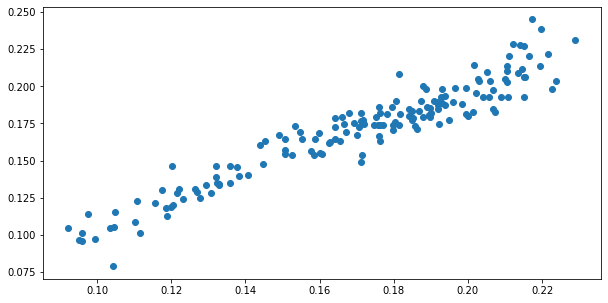

In [21]:
x = ['pitching_ratings_vsr_stuff', 'pitching_ratings_vsl_stuff', 'role_11']
    

lr.fit(df[x], bz_relief[y])

scores.append({
    'model':'stuff_and_role',
    'best_cv_score': lr.best_score_,
    'full_mse': metrics.mean_squared_error(df[y], lr.predict(df[x])),
    'full_r2': metrics.r2_score(df[y], lr.predict(df[x]))
})


plt.scatter(bz_relief[y], lr.predict(df[x]))
plt.show()

In [22]:
scoring = pd.DataFrame(scores)
scoring

,model,best_cv_score,full_mse,full_r2
0,base,-0.000189,0.000176,0.852301
1,base_with_roll,-0.000112,0.000100,0.915868
2,boost_wo_stuff,-0.000164,0.000150,0.874092
3,boost_w_stuff,-0.000159,0.000142,0.880436
4,full,-0.000106,0.000089,0.925440
5,stuff_and_role,-0.000115,0.000108,0.909376


As observed with the feature elimination process, the model with just stuff and roll doesn't perform as well as every variable from the dataset we had, but there is an argument to be made that the final model should only inlcude those three variables to avoid overfitting. I won't get into what model should ultimately be used, but it should be clear by now that there's plenty of evidence to suggest one cannot rely just on the stuff rating to produce an accurate strikeout model for pitchers in the bullpen, and something resembling stuff boost for starters in the bullpen still exists within the game.

To recap where things currently stand:
*  Pitchers who only appeared as relievers in Bronze Best-of-Seven Quick Tournmanets have differing strikeout rates when comparing their stuff.
*  This difference is best explained by the pitcher's role listed in the card database.
*  Pitchers who are listed as Starters in the card database have similar strikeout rates to Relievers despite having lower stuff than those Relievers.
*  The best way to explain this difference is by using the pticher's role on the card as indicated in the database.


#### Archetype of Pitchers Who Get the Biggest Boost
Who are the pitchers that are seeing the highest change in their strikeout rates from when they were in the rotation to when they are in the bullpen? This section looks at those pitches who faced more than 2,000 batters as both a starter only, and as a reliever only (tournaments where their games started equals their total games for a particular team, and where their games started were zero for a team). 

The top 10 pitchers as sorted by the percent increase they see in their strikeout rates when they moved to the bullpen exclusively.

In [23]:
k_diff = pd.read_csv('bronze_k_rate_diff.csv')
k_diff.head(n=10).sort_values(by='perc_increase', ascending=False)

,card_title,sp_k_rate,rp_k_rate,perc_increase,pitching_ratings_vsr_stuff,pitching_ratings_vsl_stuff,pitching_ratings_vsr_movement,pitching_ratings_vsl_movement,pitching_ratings_vsr_control,pitching_ratings_vsl_control,...,pitching_ratings_pitches_screwball,pitching_ratings_pitches_forkball,pitching_ratings_pitches_changeup,pitching_ratings_pitches_sinker,pitching_ratings_pitches_splitter,pitching_ratings_pitches_knuckleball,pitching_ratings_pitches_cutter,pitching_ratings_pitches_circlechange,pitching_ratings_pitches_knucklecurve,pitching_ratings_misc_velocity
0,Rookie Sensation RP Wayne Twitchell PHI 1972,11.4,19.0,66.7,178,168,166,158,97,97,...,-1,-1,-1,-1,-1,-1,-1,81,-1,94
1,Snapshot SP Yordano Ventura KC 2015,14.2,20.4,43.7,142,146,124,120,95,91,...,-1,-1,164,-1,-1,-1,-1,-1,-1,96
2,MLB 2021 Live SP Yusei Kikuchi SEA 2021,14.9,21.3,43.0,160,170,71,75,110,112,...,-1,-1,128,-1,-1,-1,-1,-1,-1,95
3,MLB 2021 Live SP Michael Lorenzen CIN 2021,14.8,20.7,39.9,152,134,120,106,108,104,...,-1,-1,-1,136,-1,-1,144,-1,-1,97
4,MLB 2021 Live RP Tejay Antone CIN 2021,14.7,20.5,39.5,184,160,128,108,99,95,...,-1,-1,116,150,-1,-1,-1,-1,-1,95
5,MLB 2021 Live RP Taylor Clarke ARI 2021,12.4,17.1,37.9,142,138,112,114,124,124,...,-1,-1,114,-1,-1,-1,-1,-1,-1,93
6,BUILD-A-LEGEND SP Adam Wainwright St. Louis Ca...,11.9,15.9,33.6,116,116,130,124,106,104,...,-1,-1,148,116,-1,-1,112,-1,-1,94
7,MLB 2021 Live SP Aaron Civale CLE 2021,13.2,17.5,32.6,126,134,91,99,146,150,...,-1,-1,126,-1,-1,-1,130,-1,-1,91
8,MLB 2021 Live SP Domingo German NYY 2021,16.1,21.3,32.3,160,154,77,73,134,132,...,-1,-1,140,-1,-1,-1,-1,-1,-1,95
9,Rookie Sensation SP Ralph Works DET 1909,12.7,16.7,31.5,122,122,148,144,102,99,...,-1,134,-1,-1,-1,-1,-1,-1,-1,90


Here are the bottom 10:

In [24]:
k_diff.tail(n=10).sort_values(by='perc_increase', ascending=False)

,card_title,sp_k_rate,rp_k_rate,perc_increase,pitching_ratings_vsr_stuff,pitching_ratings_vsl_stuff,pitching_ratings_vsr_movement,pitching_ratings_vsl_movement,pitching_ratings_vsr_control,pitching_ratings_vsl_control,...,pitching_ratings_pitches_screwball,pitching_ratings_pitches_forkball,pitching_ratings_pitches_changeup,pitching_ratings_pitches_sinker,pitching_ratings_pitches_splitter,pitching_ratings_pitches_knuckleball,pitching_ratings_pitches_cutter,pitching_ratings_pitches_circlechange,pitching_ratings_pitches_knucklecurve,pitching_ratings_misc_velocity
40,One Hit Wonder SP Randy Tate NYM 1975,18.1,21.9,21.0,190,192,126,124,61,59,...,-1,144,-1,-1,-1,-1,-1,-1,-1,94
41,MLB 2021 Live SP Rich Hill TB 2021,17.4,20.9,20.1,158,152,87,87,106,106,...,-1,-1,122,-1,-1,-1,104,-1,-1,89
42,BUILD-A-LEGEND SP Tim Hudson San Francisco Gia...,10.1,12.1,19.8,93,83,118,108,170,168,...,-1,93,-1,99,-1,-1,-1,-1,-1,91
43,MLB 2021 Live SP Michael Wacha TB 2021,13.7,16.4,19.7,134,140,75,77,130,130,...,-1,-1,-1,-1,-1,-1,102,172,-1,91
44,One Hit Wonder SP Steve Gerkin PHA 1945,8.7,10.0,14.9,71,71,148,142,148,142,...,-1,89,-1,-1,-1,-1,-1,-1,-1,89
45,Snapshot SP Ed Lynch CHC 1986,11.7,13.3,13.7,106,104,110,106,172,168,...,-1,-1,93,-1,-1,-1,-1,-1,-1,90
46,MLB 2021 Live SP J.A. Happ MIN 2021,13.5,15.2,12.6,122,134,65,71,128,134,...,-1,-1,124,97,-1,-1,-1,-1,-1,91
47,MLB 2021 Live SP Kohei Arihara TEX 2021,12.7,14.2,11.8,124,122,97,99,138,140,...,-1,106,-1,95,-1,-1,93,116,-1,90
48,Rookie Sensation SP Jeremy Guthrie BAL 2007,13.0,14.5,11.5,124,116,104,97,132,130,...,-1,-1,114,108,-1,-1,110,-1,-1,91
49,Rookie Sensation SP Bill Laskey SF 1982,11.1,12.1,9.0,112,97,116,108,144,146,...,-1,-1,61,118,-1,-1,-1,-1,-1,89


I won't talk about each pitcher in the last two blocks. They can be looked at in game, but I think a pattern will emerge where the pitchers with the largest increase tend to have two really good pitches and decent velocity, where the pitchers with the lowest boost are the opposite. But let's see if we can visualize this.

First, the relationship between the top two pitches summed and the percent increase to strikeout rate.

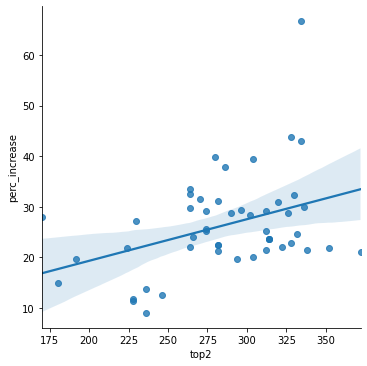

In [25]:
pitches = pd.DataFrame(np.sort(k_diff[['pitching_ratings_pitches_fastball', 'pitching_ratings_pitches_slider',
       'pitching_ratings_pitches_curveball',
       'pitching_ratings_pitches_screwball',
       'pitching_ratings_pitches_forkball',
       'pitching_ratings_pitches_changeup', 'pitching_ratings_pitches_sinker',
       'pitching_ratings_pitches_splitter',
       'pitching_ratings_pitches_knuckleball',
       'pitching_ratings_pitches_cutter',
       'pitching_ratings_pitches_circlechange',
       'pitching_ratings_pitches_knucklecurve']].values), index=k_diff.index)

k_diff['top2'] = pitches[10] + pitches[11]
k_diff['diff3'] = pitches[10] - pitches[9]

sns.lmplot(data=k_diff,
           x='top2',
           y='perc_increase')

The differene from a pitcher's second best pitch to their third best.

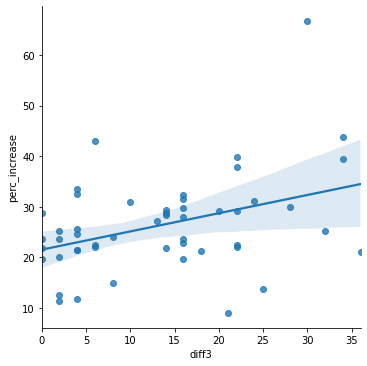

In [26]:
sns.lmplot(data=k_diff,
           x='diff3',
           y='perc_increase')

Finally the pitcher's velocity.

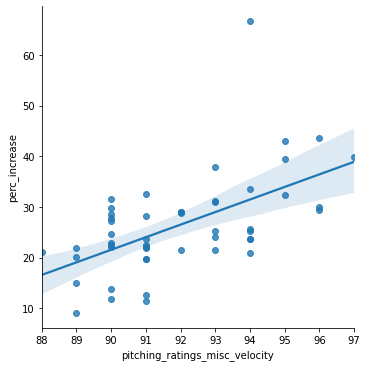

In [27]:
sns.lmplot(data=k_diff,
           x='pitching_ratings_misc_velocity',
           y='perc_increase')

A pitcher's velocity appears to have the strongest correlation with a pitcher's k_rate increase. I'll throw together a quick model and see how well this can be predicted.

{'top2': 0.020509869850251425,
 'diff3': 0.21462760007859996,
 'pitching_ratings_misc_velocity': 2.0087219596062615}

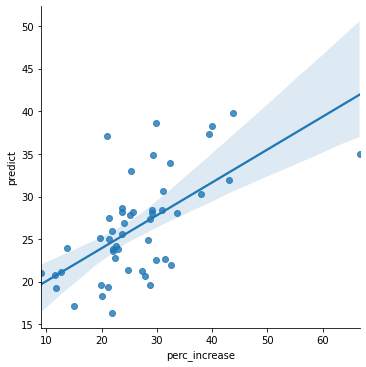

In [28]:
x = ['top2', 'diff3', 'pitching_ratings_misc_velocity']

y = 'perc_increase'

lr.fit(k_diff[x], k_diff[y])

k_diff['predict'] = lr.predict(k_diff[x])

sns.lmplot(data=k_diff, x='perc_increase', y='predict')

dict(zip(x, lr.coef_))

In [29]:
print(metrics.mean_squared_error(k_diff['perc_increase'], k_diff['predict']))

55.987597179219776


Every mph in velocity is worth about 2 percent extra in a pitcher's strikeout rate when moved to the pen. It's not the greatest model in the world (MSE of .005 or about half a percent on average), but the fact that it's even that close just using three variables is pretty damning of stuff boost still in the game. I'm sure if I added total number of pitches over a certain threshold (50 in the base game) it would improve the model but I haven't settled on what's a good threshold in Perfect Team for that yet.

#### League Data
I'm going to quickly breeze through this section since a lot of what is shown is the same as what's already been covered. This phenomena shown in bronze is evident in league data as well, and not .

For league data, I used data from the weeks ending July 4th and July 11th of Perfect League and Diamond League data provided by users to DRC's Discord channel, and publically available by anyone there to use and analyze.

I'll skip the look at relief pitchers as only starters since there's no relievers who only start in the league. However, there are plenty of starters who only ever appeared as relievers for their teams during the season. Given that splits are available for league data, it'll be a little easier to explore the impact of role on stuff boost.

First up, relievers who faced more than 1,000 right-handed batters during the two week period.

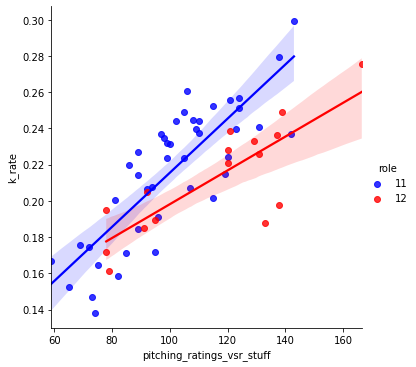

In [30]:
vsr_relief = pd.read_csv('vsr_league_relief.csv', index_col='card_id')
vsr_relief['pitching_ratings_vsr_stuff'] = vsr_relief['pitching_ratings_vsr_stuff'] / 2

vsr_relief['k_rate'] = vsr_relief['k'] / vsr_relief['bf']

sns.lmplot(data=vsr_relief.loc[vsr_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsr_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

It's a familiar looking sight at this point. Starters with lower stuff than relievers have similar, or higher, strikeout rates. In fact the two pitchers (Satchel Paige and FL Nate Pearson) with the highest strikeout rates are starters in the bullpen.

How about versus left-handed batters?

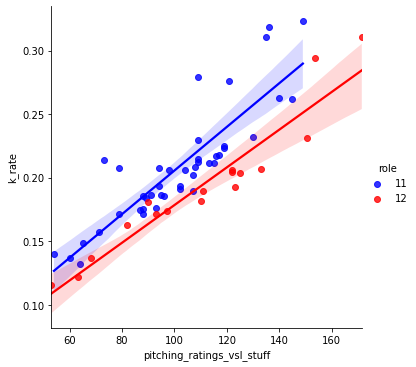

In [31]:
vsl_relief = pd.read_csv('vsl_league_relief.csv', index_col='card_id')
vsl_relief['pitching_ratings_vsl_stuff'] = vsl_relief['pitching_ratings_vsl_stuff'] / 2

vsl_relief['k_rate'] = vsl_relief['k'] / vsl_relief['bf']

sns.lmplot(data=vsl_relief.loc[vsl_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsl_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

This plot looks a little different from the others in that there doesn't appear to be a "cross-over" at lower stuff ratings compred to bronze, and league data versus RHB. Perhaps as stuff keeps decreaseing there would be a convergence. Despite this, there's still the difference in strikeout rates for starters and relievers.

## Card Database Discrepancies
That wraps up the look at in-game data that was generated that I feels clearly shows there's still stuff boost, or something so similar to stuff boost that is virtual indistinguishable. 

I want to turn now to the online card databse and what's presented there, to what's presented in-game. This section comes after the live update that occured on July 26th, 2021 and uses the card database that was updated on the OOTP website sometime that afternoon. The ratings that come out of the game were pulled from my card collection that evening after I cleared my card cache. 

As of this writing, I have 3,371 unique cards in my collection, so I can only use these cards to compare to what's in the card database, which has 4,835 cards (it's missing at least six cards that I have in my collection, but could be more). Of those 3,371 unique cards, 139 of them have stuff ratings that do not match-up. I'm going to exclude the two catchers from this since they're not listed as pitchers in the database, and focus on the actual listed pitchers. Of the 137 pitchers that do not match-up between what's in-game and in the card database, they're all listed as relievers in the database, with all but eight part of the Live Collection (2 One Hit Wonders and 6 Unsung Heroes). 

All but 10 of these relievers have a stuff rating greater than what's shown in-game. When looking at who has the biggest discrepancies, it's my belief that the rating being shown to players in-game is actually wrong and not accurate, and the values listed in the online card database are the right ones. The players with the biggest discrepancies all would likely get large boosts to stuff when properly lsited as relievers in the base game. Yet, their stuff is all lower than what the card database shows.

### Positive Stuff Boost

###### Camilo Doval
Doval has the largest discrepancy between the DB and the game, with 19 more points vL in the DB and 26 more vR. He's only got two pitches (80 and 69) and throws 100mph.


###### Jim Suchecki
Suchecki is a One Hit Wonder, and not a Live card. He's only got two pitches and throws 95mph. The card DB has him with 20 pts more to both vL and vR stuff.

###### Miguel Diaz
Diaz is listed as having 17 points more vL in the DB and 20 more vR. He's got two pitches that are 88+ in-game, his third pitch is a 59, and throws 97 mph.

I'm going to skip over both Bob Moorhead and Dick Lanahan who are not Live cards. They both have only two pitches. 

###### Garrett Crochet
Live Crochet (not the Future Legend) has three pitches, but only two are good (82, 63, 25), but he throws 100 mph. The card DB says he has +20 vL and +16 vR for stuff. 

###### Kyle Cody
The last example I'm going to use for pitchers who receive the most stuff boost in the card DB is live Kyle Cody. The DB gives him +13 vL and +15 vR. He throws 97 and has two pitches in the low 80s, and a third at 62.


### Negative Stuff Boost
These are all examples of pitchers that would be expected of having a significant stuff boost when moved to the bullpen. What about pitchers that actually see a negative stuff boost when looking at the card databse?

###### Jhoulys Chacin
Live Chacin has -4 vL and -3 vR stuff when looking at the card DB. He has six pitches all around 55ish, and throws 91. Typically when looking at pitches who would not receive a boost, the more pitches they have above a certain level (50 base game) the less boost they get. As we've seen with velocity, that also plays a big role in boost.

###### Josh Lindblom
Lindblom has six pitches (this will become a trend, trust me), throws 92 and gets a -3 penalty to both vL and vR.

###### David Price
Live David Price has five pitches, throws 94 and gets a -3 penalty to both vL and vR.

###### Brooks Raley
Raley has six pitches, throws 91 and gets a -3 penalty to both vL and vR. 

I could go on, but it's clear at this point.

## Conclusions

It's my belief stuff boost is still modeled in the game engine within Perfect Team. It may not be displayed in the game when switching a pitchers role from SP to RP as it still happens within the base game, and previous versions of OOTP, but the engine is still applying the boost. Even if it's not "stuff boost" as the community has come to know it that's happening behind the scenes, to me it comes across so similar to how stuff boost works that it's a distinction without a difference.